# Parsing XML with lxml

XML is a general purpose markup language that was designed to exchange data among systems. There are hundreds of "XML schemas" that are used for particular applications or uses. 

## Getting some data

Let's get the XML file from the "US Overseas loans and grants" that was downloadable from here (it was retired august 2015): http://catalog.data.gov/dataset/us-overseas-loans-and-grants-greenbook-usaid-1554

In [1]:
# Code for getting the data:
# URL not available, instead the original file is provided with the Notebook. 
#from urllib import urlretrieve
#link = 'https://eads.usaid.gov/gbk/data/files/us_foreign_assistance.xml'
#urlretrieve(link, "fa.xml")

In [2]:
%ls -l *.xml

-rw-r--r--  1 msicilia  staff  2583173  8 may  2015 fa.xml


In [3]:
!head -n12 fa.xml

Note that this is a relatively simple XML. You can see a more complex one for example here: http://www.ec.tuwien.ac.at/~dorn/Courses/KM/Resources/hrxml/HR-XML-2_3/SIDES/StaffingInvoice.html

Information in XML is not necessarily tabular, but it can be complex and with a nested structure, so there is no single way of importing that into a tabular structure (DataFrame).

## Loading the XML into memory

In [4]:
from lxml import objectify
parsed = objectify.parse('fa.xml')
root = parsed.getroot()
print root.tag
print root.attrib
print root.countchildren()

ForeignAssistance
{}
8278


We can see in the XML file that it follows a simple structure with each entry as a ForeignAssistanceRow element.

The expression root.ForeignAssistanceRow generates one element for each ForeignAssistanceRow element:

In [5]:
country=[]
name=[]
unit =[]
year=[]
amount=[]
kind =[]
program = []
for row in root.ForeignAssistanceRow:
    country.append(row.RecipientCountry.text)
    name.append(row.ProgramName.text)
    unit.append(row.UnitName.text)
    year.append(row.FiscalYear.text)
    amount.append(row.Obligations.text)
    kind.append(row.AssistanceType.text)
    program.append(row.ProgramName.text)
    
print len(country), len(name), len(unit), len(year), len(amount)

8278 8278 8278 8278 8278


In [6]:
import pandas as pd
data = pd.DataFrame()
data['country'] = country
data['name'] = name
data['unit'] = unit
data['year'] = year
data['amount'] = amount
data['type'] = kind
data['program'] = program

# Always remember to check types and convert if needed:
print type(data['amount'][0])
data['amount'] = pd.Series(amount, dtype="int32")
print type(data['amount'][0])

data.head(5)

<type 'str'>
<type 'numpy.int32'>


,country,name,unit,year,amount,type,program
0,Afghanistan,Child Survival and Health,Constant 2011 $US,2002,2691390,Economic,Child Survival and Health
1,Afghanistan,Child Survival and Health,Constant 2011 $US,2003,58817159,Economic,Child Survival and Health
2,Afghanistan,Child Survival and Health,Constant 2011 $US,2004,41877130,Economic,Child Survival and Health
3,Afghanistan,Child Survival and Health,Constant 2011 $US,2005,41467658,Economic,Child Survival and Health
4,Afghanistan,Child Survival and Health,Constant 2011 $US,2006,42463433,Economic,Child Survival and Health


## Some basic analysis

In [7]:
yearly = data.groupby(year)

In [8]:
per_year = yearly["amount"].sum()
print type(per_year)
per_year.head(5)

<class 'pandas.core.series.Series'>


1946    1.047179e+09
1947    1.499747e+09
1948    1.491180e+09
1949    7.399670e+08
1950    3.812157e+09
Name: amount, dtype: float64

/Users/msicilia/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


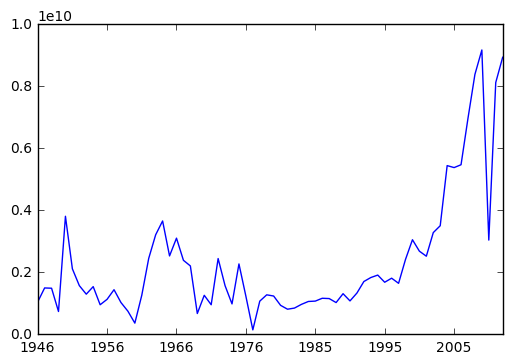

In [9]:
%matplotlib inline
per_year.plot()

Note: we have not checked that these are constant dollars!

<class 'pandas.core.groupby.DataFrameGroupBy'>
country
Afghanistan    4.437943e+10
Albania        2.099278e+09
Algeria        1.522753e+09
Name: amount, dtype: float64
---------
country
Afghanistan             4.437943e+10
Bangladesh              1.920549e+10
Brazil                  1.823752e+10
Asia (not specified)    1.737289e+10
Bolivia                 1.428634e+10
Name: amount, dtype: float64


/Users/msicilia/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


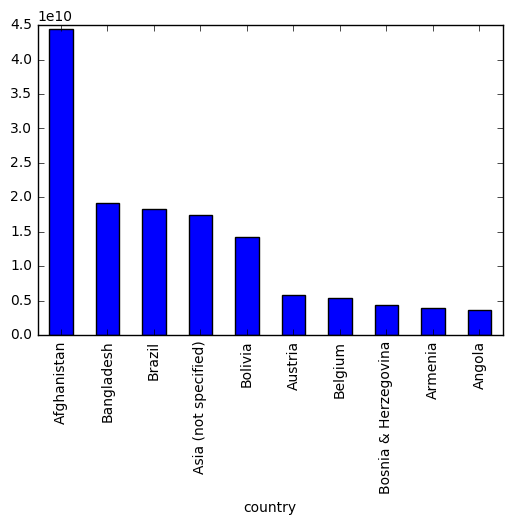

In [10]:
countrywise = data.groupby("country")
print type(countrywise)

per_country = countrywise["amount"].sum()
print per_country.head(3)
print "---------"

# Sort and visualize:
per_country.sort(ascending=False)
print per_country.head(5)
per_country.head(10).plot(kind="bar")

Now let's try to do that with homogeneous currency data.

{'Historical $US': array([   8,    9,   10, ..., 8275, 8276, 8277]), 'Constant 2011 $US': array([   0,    1,    2, ..., 8263, 8264, 8265])}
                               amount
unit                                 
Constant 2011 $US count  4.156000e+03
                  mean   2.481762e+07
                  std    1.159899e+08
                  min   -2.145264e+09
                  25%    4.999602e+05
                  50%    2.517717e+06
                  75%    1.355126e+07
                  max    2.100703e+09
Historical $US    count  4.122000e+03
                  mean   1.345892e+07
                  std    7.355242e+07
                  min   -1.639549e+09
                  25%    3.000000e+05
                  50%    1.557898e+06
                  75%    7.730074e+06
                  max    2.100703e+09
----------------
<class 'pandas.core.frame.DataFrame'>
----------------
29


/Users/msicilia/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


country
Afghanistan             2.429522e+10
Brazil                  1.515711e+10
Bangladesh              1.281125e+10
Asia (not specified)    1.126589e+10
Bolivia                 9.569419e+09
Belgium                 4.774177e+09
Austria                 4.691108e+09
Bosnia & Herzegovina    2.448232e+09
Armenia                 2.214525e+09
Angola                  2.044264e+09
Name: amount, dtype: float64

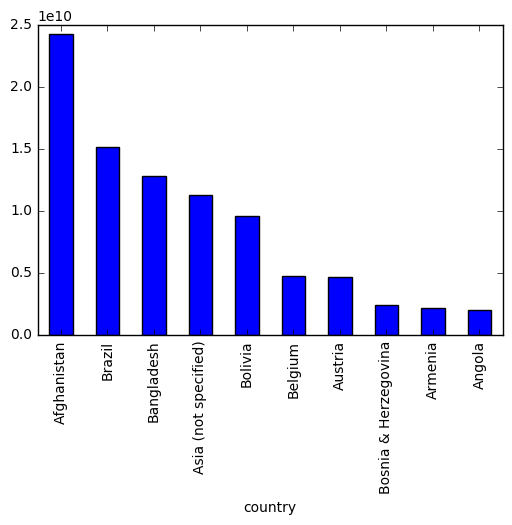

In [11]:
# Create groups based on unit:
currencywise = data.groupby("unit")
print currencywise.indices
print currencywise.describe()
print "----------------"


# Each group is a DataFrame:
constantdollars = currencywise.get_group("Constant 2011 $US")
print type(constantdollars)
print "----------------"


# Now we group by country:
percountry2 = constantdollars.groupby("country")
final = percountry2["amount"].sum()
final.sort(ascending=False)
print len(final)
final.head(10).plot(kind="bar")
final.head(10)

## Analyzing the type of assistance

We can get the different types of assistance:

In [12]:
programs = data["program"].unique()
print type(programs)
print len(programs)
programs

<type 'numpy.ndarray'>
21


array(['Child Survival and Health',
       'Department of Defense Security Assistance',
       'Development Assistance',
       'Economic Support Fund/Security Support Assistance',
       'Food For Education', 'Global HIV/AIDS Initiative',
       'Global Health and Child Survival', 'Inactive Programs',
       'Migration and Refugee Assistance', 'Narcotics Control',
       'Nonproliferation, Anti-Terrorism, Demining and Related',
       'Other Active Grant Programs', 'Other Food Aid Programs',
       'Other State Assistance', 'Other USAID Assistance',
       'Other USDA Assistance', 'Peace Corps', 'Title I', 'Title II',
       'Millennium Challenge Corporation',
       'Voluntary Contributions to Multilateral Organizations, Total'], dtype=object)

In [13]:
byprogram = data.groupby("program")
len(byprogram)
amountbyprogram = byprogram["amount"].sum()
amountbyprogram.sort(ascending=False)
amountbyprogram

/Users/msicilia/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


program
Other USAID Assistance                                          4.769048e+10
Economic Support Fund/Security Support Assistance               2.805559e+10
Title II                                                        1.794273e+10
Title I                                                         1.252579e+10
Narcotics Control                                               9.986684e+09
Inactive Programs                                               7.423651e+09
Department of Defense Security Assistance                       6.170455e+09
Development Assistance                                          5.439410e+09
Voluntary Contributions to Multilateral Organizations, Total    3.481346e+09
Other Food Aid Programs                                         3.116252e+09
Global Health and Child Survival                                2.936038e+09
Migration and Refugee Assistance                                2.822740e+09
Other Active Grant Programs                                     2.25

In [14]:
sixtop = amountbyprogram[:6]
sixtop

program
Other USAID Assistance                               4.769048e+10
Economic Support Fund/Security Support Assistance    2.805559e+10
Title II                                             1.794273e+10
Title I                                              1.252579e+10
Narcotics Control                                    9.986684e+09
Inactive Programs                                    7.423651e+09
Name: amount, dtype: float64

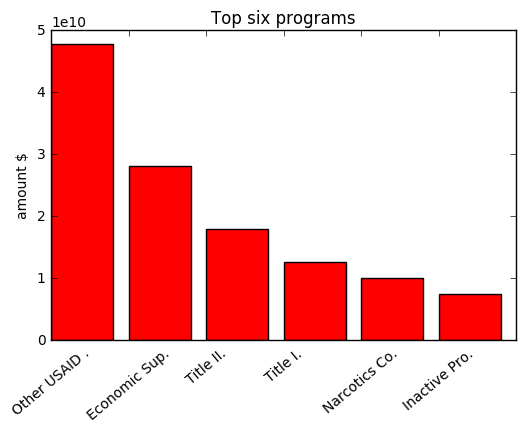

In [15]:

names = [name[:12]+"." for name in list(sixtop.index)]
pos = range(len(sixtop))


import matplotlib.pyplot as plt
line = plt.bar(pos, sixtop, color="r")
plt.xticks(pos, names, rotation=40)
plt.title("Top six programs")
plt.ylabel("amount $")
plt.savefig("programs.jpg", bbox_size=200)